In [4]:
import os
import gc
import cv2
import yaml
import json
import torch
import shutil
import numpy as np
import pandas as pd
from glob import glob
from random import shuffle
from tqdm.notebook import tqdm
from collections import Counter
from PIL import Image, ImageFilter
from typing import List, Tuple, Generator, Any, Dict

from ray import tune
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from ray.tune.schedulers import PopulationBasedTraining
from torchvision.transforms import RandomChoice, RandomRotation, GaussianBlur, Resize

from nomeroff_net.tools.mcm import modelhub, get_device_torch
from nomeroff_net.tools.image_processing import normalize_img
from nomeroff_net.tools.ocr_tools import (StrLabelConverter,
                                          decode_prediction,
                                          decode_batch)
from nomeroff_net.nnmodels.ocr_model import NPOcrNet, weights_init
from nomeroff_net.data_modules.numberplate_ocr_data_module import OcrNetDataModule

import matplotlib.pyplot as plt
%matplotlib inline

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [2]:
from convert_to_yolo import convert_dataset_to_yolo_format
from ultralytics import YOLO

# from datasets import load_metric
from evaluate import load
from transformers import TrOCRProcessor, VisionEncoderDecoderModel, default_data_collator, \
                         Seq2SeqTrainer, Seq2SeqTrainingArguments

In [ ]:
!python scripts/trocr_finetune.py --exp_name aug_trocr_base_1500_bs8 \
    --max_steps 1500 --eval_steps 300 --aug --ocr_folder all --train_batch_size 6

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Args saved in: exps/aug_trocr_base_1500_bs8_Ru
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/nfs/home/isaitov/miniconda3/envs/nl39/lib/python3.9/site-packages/transformers/models/trocr/processing_trocr.py:134: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(
Running evaluation...
/nfs/home/isaitov/miniconda3/envs/nl39/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version

 53%|█████████████████████▊                   | 163/306 [14:42<12:13,  5.13s/it]


 85%|██████████████████████████████████▊      | 260/306 [22:58<03:51,  5.02s/it]


100%|████████████████████████████████████████▊| 305/306 [27:24<00:06,  6.30s/it]
                                                                                
{'eval_loss': 0.49181488156318665, 'eval_cer': 0.02515387970726506, 'eval_runtime': 1657.1548, 'eval_samples_per_second': 2.953, 'eval_steps_per_second': 0.185, 'epoch': 0.07}
100%|█████████████████████████████████████████| 306/306 [27:31<00:00,  5.89s/it]
                                                                                /nfs/home/isaitov/miniconda3/envs/nl39/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
{'loss': 0.3191, 'learning_rate': 3.0133333333333335e-05, 'epoch': 0.15}        
 40%|████████████████                        | 600/1500 [50:46<23:45,  1.58s/it]/nfs/home/isaitov/miniconda3/envs/nl39/

 43%|█████████████████▋                       | 132/306 [11:46<14:52,  5.13s/it]


 75%|██████████████████████████████▋          | 229/306 [20:43<06:24,  5.00s/it]


100%|████████████████████████████████████████▊| 305/306 [27:04<00:05,  5.09s/it]
                                                                                
{'eval_loss': 0.2693610191345215, 'eval_cer': 0.0018417098822274996, 'eval_runtime': 1636.7362, 'eval_samples_per_second': 2.989, 'eval_steps_per_second': 0.187, 'epoch': 0.15}
100%|█████████████████████████████████████████| 306/306 [27:11<00:00,  4.80s/it]
                                                                                /nfs/home/isaitov/miniconda3/envs/nl39/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
{'loss': 0.2337, 'learning_rate': 2.0133333333333336e-05, 'epoch': 0.22}        
 60%|██████████████████████▊               | 900/1500 [1:32:55<15:30,  1.55s/it]/nfs/home/isaitov/miniconda3/envs/nl39

 33%|█████████████▌                           | 101/306 [08:31<17:01,  4.98s/it]


 65%|██████████████████████████▌              | 198/306 [17:25<09:04,  5.04s/it]


 96%|███████████████████████████████████████▌ | 295/306 [25:56<01:03,  5.79s/it]


100%|████████████████████████████████████████▊| 305/306 [26:54<00:05,  5.86s/it]
                                                                                
{'eval_loss': 0.32970142364501953, 'eval_cer': 0.0005573595696214802, 'eval_runtime': 1627.7362, 'eval_samples_per_second': 3.006, 'eval_steps_per_second': 0.188, 'epoch': 0.22}
100%|█████████████████████████████████████████| 306/306 [27:02<00:00,  5.80s/it]
                                                                                /nfs/home/isaitov/miniconda3/envs/nl39/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
{'loss': 0.1594, 'learning_rate': 1.0133333333333333e-05, 'epoch': 0.29}        
 80%|█████████████████████████████▌       | 1200/1500 [2:15:06<08:05,  1.62s/it]/nfs/home/isaitov/miniconda3/envs/nl3

 27%|███████████▎                              | 82/306 [07:20<19:04,  5.11s/it]

# TrOCR augment

## dataload

In [3]:
ru_ocr_folder = '/nfs/home/isaitov/NL/data/autoriaNumberplateOcrRu-2021-09-01'
ua_ocr_folder = '/nfs/home/isaitov/NL/data/autoriaNumberplateOcrUa-2023-04-18'

In [4]:
train_ru_ocr_folder, val_ru_ocr_folder, test_ru_ocr_folder = os.path.join(ru_ocr_folder, 'train'),  \
                                                             os.path.join(ru_ocr_folder, 'val'),   \
                                                             os.path.join(ru_ocr_folder, 'test')
train_ua_ocr_folder, val_ua_ocr_folder, test_ua_ocr_folder = os.path.join(ua_ocr_folder, 'train'), \
                                                             os.path.join(ua_ocr_folder, 'val'),  \
                                                             os.path.join(ua_ocr_folder, 'test')

In [5]:
def get_names_and_np(folder:str):
    data = []
    for fn in os.listdir(os.path.join(folder, 'img')):
        with open(os.path.join(folder, 'ann', f"{fn.rsplit('.', 1)[0]}.json"), 'r') as f:
            js_data = json.load(f)
            data.append([fn, js_data['description']])
    return data
    

def get_df_from_folder(train_folder:str, val_folder:str, test_folder:str, columns=['file_name', 'text']):
    train_data, val_data, test_data = get_names_and_np(train_folder), \
                                      get_names_and_np(val_folder),   \
                                      get_names_and_np(test_folder)
    train_df, val_df, test_df = pd.DataFrame(train_data, columns=columns), \
                                pd.DataFrame(val_data, columns=columns),   \
                                pd.DataFrame(test_data, columns=columns)
    return train_df, val_df, test_df


try:
    train_df = pd.read_csv('train_df.csv')
    val_df = pd.read_csv('val_df.csv')
    test_df = pd.read_csv('test_df.csv')
except:
    print('Error. re-init')
    train_df, val_df, test_df = get_df_from_folder(train_ru_ocr_folder, val_ru_ocr_folder, test_ru_ocr_folder)

In [6]:
class Dilation(torch.nn.Module):

    def __init__(self, kernel=3):
        super().__init__()
        self.kernel=kernel

    def forward(self, img):
        return img.filter(ImageFilter.MaxFilter(self.kernel))

class Erosion(torch.nn.Module):

    def __init__(self, kernel=3):
        super().__init__()
        self.kernel=kernel

    def forward(self, img):
        return img.filter(ImageFilter.MinFilter(self.kernel))

class Underline(torch.nn.Module):

    def __init__(self):
        super().__init__()

    def forward(self, img):
        img_np = np.array(img.convert('L'))
        black_pixels = np.where(img_np < 50)
        try:
            y1 = max(black_pixels[0])
            x0 = min(black_pixels[1])
            x1 = max(black_pixels[1])
        except:
            return img
        for x in range(x0, x1):
            for y in range(y1, y1-3, -1):
                try:
                    img.putpixel((x, y), (0, 0, 0))
                except:
                    continue
        return img

class KeepOriginal(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, img):
        return img    

In [13]:
class IAMDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128, train=False, size=(384,384)):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length
        self.transform = RandomChoice([RandomRotation(degrees=(-10, 10), expand=True, fill=255),
                                       GaussianBlur(3),
                                       Dilation(3),
                                       Erosion(3),
                                       Resize((size[0] // 3, size[1] // 3), interpolation=0),
                                       Underline(),
                                       KeepOriginal()])
        self.train = train

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        
        
        #fig, ax = plt.subplots(1,2)
        #ax[0].imshow(image)
        #print(np.array(image).shape)
        if self.train:
            image = self.transform(image)
        #print(np.array(image).shape)
        #ax[1].imshow(image)
        #plt.show()
        print(np.array(image))
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        
        print(pixel_values, pixel_values.shape)
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, 
                                          padding="max_length", 
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [14]:
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
train_dataset = IAMDataset(root_dir=os.path.join(train_ru_ocr_folder, 'img/'),
                           df=train_df,
                           processor=processor,
                           train=True)
val_dataset = IAMDataset(root_dir=os.path.join(val_ru_ocr_folder, 'img/'),
                         df=val_df,
                         processor=processor)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


(79, 363, 3)
(79, 363, 3)


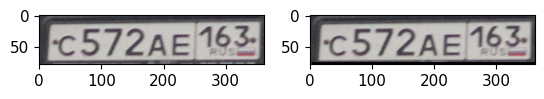

(45, 209, 3)
(45, 209, 3)


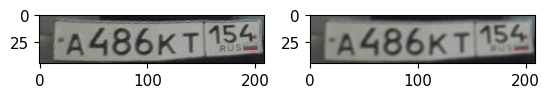

(21, 99, 3)
(21, 99, 3)


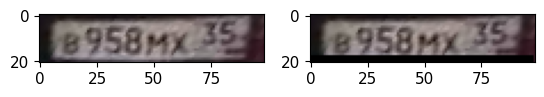

(42, 193, 3)
(50, 195, 3)


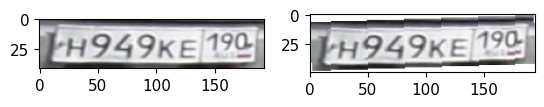

(59, 275, 3)
(59, 275, 3)


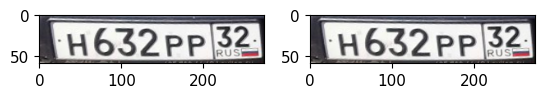

(44, 206, 3)
(68, 210, 3)


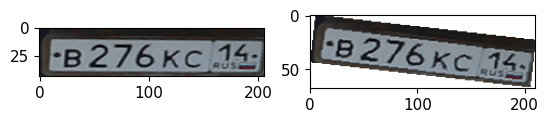

(22, 103, 3)
(32, 105, 3)


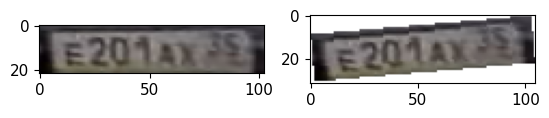

(80, 368, 3)
(92, 372, 3)


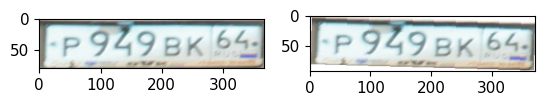

(62, 285, 3)
(62, 285, 3)


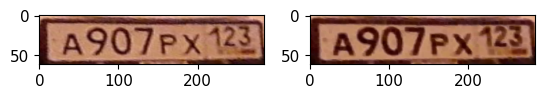

(85, 392, 3)
(85, 392, 3)


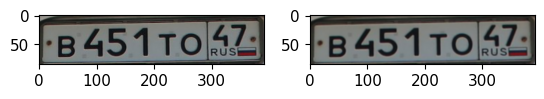

(65, 302, 3)
(65, 302, 3)


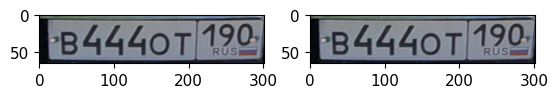

(43, 197, 3)
(43, 197, 3)


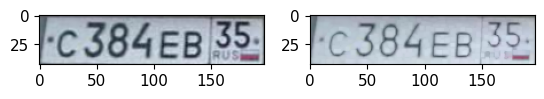

In [41]:
for i, data in enumerate(train_dataset):
    if i > 10:
        break

## modeling

In [14]:
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1")

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

training_args = Seq2SeqTrainingArguments(
    output_dir='third_exp',
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    load_best_model_at_end=True,
    fp16=True,
    logging_steps=2,
    save_steps=1000,
    eval_steps=200,
    max_steps=1500
)

cer_metric = load("cer")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

## experiments

In [11]:
torch.cuda.set_device(0)

In [16]:
# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=default_data_collator,
)

/nfs/home/isaitov/miniconda3/envs/nl39/lib/python3.9/site-packages/transformers/models/trocr/processing_trocr.py:134: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


In [ ]:
trainer.train()

## res analysis

In [36]:
ray_exp_1_path = "/nfs/home/isaitov/NL/ray_results_copy/tune_transformer_pbt"
obj_paths = glob(os.path.join(ray_exp_1_path, '_obj*'))
obj_paths[:3]

['/nfs/home/isaitov/NL/ray_results_copy/tune_transformer_pbt/_objective_865bf_00007_7_2023-05-05_01-26-45',
 '/nfs/home/isaitov/NL/ray_results_copy/tune_transformer_pbt/_objective_865bf_00021_21_2023-05-05_02-42-37',
 '/nfs/home/isaitov/NL/ray_results_copy/tune_transformer_pbt/_objective_865bf_00037_37_2023-05-05_03-59-44']

In [37]:
os.listdir(obj_paths[0])

['events.out.tfevents.1683370501.mars',
 'events.out.tfevents.1683373823.mars',
 'events.out.tfevents.1683313288.mars',
 'params.json',
 'params.pkl',
 'result.json',
 'events.out.tfevents.1683239205.mars',
 'stdout',
 'stderr',
 'progress.csv',
 'events.out.tfevents.1683252965.mars',
 'events.out.tfevents.1683463129.mars',
 'checkpoint_-00001']

In [49]:
from operator import itemgetter

In [52]:
results = []
for obj_path in obj_paths:
    with open (os.path.join(obj_path, 'result.json'), 'r') as f:
        for line in f:
            results.append(itemgetter('eval_loss', 'eval_cer', 'config')(json.loads(line)))
results

[(0.35909557342529297,
  0.012916202200358648,
  {'per_device_train_batch_size': 2,
   'per_device_eval_batch_size': 8,
   'num_train_epochs': 1,
   'weight_decay': 0.0,
   'warmup_ratio': 0.147816842918857,
   'learning_rate': 1.6255057858173108e-06,
   'max_steps': 1295}),
 (0.3601960241794586,
  0.013061600348955557,
  {'per_device_train_batch_size': 2,
   'per_device_eval_batch_size': 8,
   'num_train_epochs': 1,
   'weight_decay': 0.0,
   'warmup_ratio': 0.147816842918857,
   'learning_rate': 1.6255057858173108e-06,
   'max_steps': 1295}),
 (0.2593519389629364,
  0.003174526244365822,
  {'per_device_train_batch_size': 2,
   'per_device_eval_batch_size': 8,
   'num_train_epochs': 1,
   'weight_decay': 0.0,
   'warmup_ratio': 0.147816842918857,
   'learning_rate': 1.6255057858173108e-06,
   'max_steps': 1295}),
 (0.3601960241794586,
  0.013061600348955557,
  {'per_device_train_batch_size': 2,
   'per_device_eval_batch_size': 8,
   'num_train_epochs': 1,
   'weight_decay': 0.0,
   'w

In [53]:
sorted_results_by_eval_cer = sorted(results, key=lambda x: x[1])

In [54]:
sorted_results_by_eval_cer

[(0.22818626463413239,
  0.0007512237677506907,
  {'per_device_train_batch_size': 2,
   'per_device_eval_batch_size': 8,
   'num_train_epochs': 1,
   'weight_decay': 0.08000000000000002,
   'warmup_ratio': 0.10661174902595053,
   'learning_rate': 5.913964564987421e-06,
   'max_steps': 756}),
 (0.22818626463413239,
  0.0007512237677506907,
  {'per_device_train_batch_size': 2,
   'per_device_eval_batch_size': 8,
   'num_train_epochs': 1,
   'weight_decay': 0.08000000000000002,
   'warmup_ratio': 0.10661174902595053,
   'learning_rate': 5.913964564987421e-06,
   'max_steps': 756}),
 (0.23556476831436157,
  0.000775456792516842,
  {'per_device_train_batch_size': 2,
   'per_device_eval_batch_size': 8,
   'num_train_epochs': 1,
   'weight_decay': 0.09600000000000002,
   'warmup_ratio': 0.05385313349533778,
   'learning_rate': 3.943582504683384e-06,
   'max_steps': 931}),
 (0.23463526368141174,
  0.000775456792516842,
  {'per_device_train_batch_size': 2,
   'per_device_eval_batch_size': 8,
  

## Aug & normalize

In [ ]:
import os
import gc
import json
import argparse
import numpy as np
import pandas as pd

from ray import tune
from evaluate import load
from ray.tune.schedulers import PopulationBasedTraining
from transformers import TrOCRProcessor, VisionEncoderDecoderModel, default_data_collator, \
                         Seq2SeqTrainer, Seq2SeqTrainingArguments

from src.dataload import IAMDataset


def get_names_and_np(folder:str):
    data = []
    for fn in os.listdir(os.path.join(folder, 'img')):
        with open(os.path.join(folder, 'ann', f"{fn.rsplit('.', 1)[0]}.json"), 'r') as f:
            js_data = json.load(f)
            data.append([fn, js_data['description']])
    return data

def get_df_from_folder(train_folder:str, val_folder:str, test_folder:str, columns=['file_name', 'text']):
    train_data, val_data, test_data = get_names_and_np(train_folder), \
                                      get_names_and_np(val_folder),   \
                                      get_names_and_np(test_folder)
    train_df, val_df, test_df = pd.DataFrame(train_data, columns=columns), \
                                pd.DataFrame(val_data, columns=columns),   \
                                pd.DataFrame(test_data, columns=columns)
    return train_df, val_df, test_df


def update_model_config(model):
    # set special tokens used for creating the decoder_input_ids from the labels
    model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
    model.config.pad_token_id = processor.tokenizer.pad_token_id
    # make sure vocab size is set correctly
    model.config.vocab_size = model.config.decoder.vocab_size

    # set beam search parameters
    model.config.eos_token_id = processor.tokenizer.sep_token_id
    model.config.max_length = 64
    model.config.early_stopping = True
    model.config.no_repeat_ngram_size = 3
    model.config.length_penalty = 2.0
    model.config.num_beams = 4
    return model


def model_init(trial):
    model = VisionEncoderDecoderModel.from_pretrained(
        'microsoft/trocr-base-stage1')
    model = update_model_config(model)
    return model


def compute_metrics(pred):
    cer_metric = load('cer')
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)
    cer_metric = load("cer")
    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}


if __name__ == '__main__':
    
    dict_ocr_folders = {'Am': '/nfs/home/isaitov/NL/data/autoriaNumberplateOcrAm-2022-11-21-all/',
                        'Eu': '/nfs/home/isaitov/NL/data/autoriaNumberplateOcrEu-2023-04-25/',
                        'Kg': '/nfs/home/isaitov/NL/data/autoriaNumberplateOcrKg-2022-11-30/',
                        'Kz': '/nfs/home/isaitov/NL/data/autoriaNumberplateOcrKz-2022-11-29/',
                        'Su': '/nfs/home/isaitov/NL/data/autoriaNumberplateOcrSu-2023-03-10/',
                        'Ge': '/nfs/home/isaitov/NL/data/autoriaNumberplateOcrGe-2022-11-29/',
                        'Ua': '/nfs/home/isaitov/NL/data/autoriaNumberplateOcrUa-2023-04-18/',
                        'Md': '/nfs/home/isaitov/NL/data/autoriaNumberplateOcrMd-2023-01-27/',
                        'By': '/nfs/home/isaitov/NL/data/autoriaNumberplateOcrBy-2021-08-27/'}
    
    cer_metric = load('cer')
    processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
    
    for key in dict_ocr_folders:
    
        ocr_folder = dict_ocr_folders[key]
        train_ocr_folder, val_ocr_folder, test_ocr_folder = os.path.join(ocr_folder, 'train'),  \
                                                            os.path.join(ocr_folder, 'val'),   \
                                                            os.path.join(ocr_folder, 'test')

        try:
            train_df = pd.read_csv(os.path.join(ocr_folder, 'train_df.csv'))
            val_df = pd.read_csv(os.path.join(ocr_folder, 'val_df.csv'))
            test_df = pd.read_csv(os.path.join(ocr_folder, 'test_df.csv'))
        except:
            print('Error. re-init')
            train_df, val_df, test_df = get_df_from_folder(train_ocr_folder, val_ocr_folder, test_ocr_folder)
            train_df.to_csv(os.path.join(ocr_folder, 'train_df.csv'), index=False)
            val_df.to_csv(os.path.join(ocr_folder, 'val_df.csv'), index=False)
            test_df.to_csv(os.path.join(ocr_folder, 'test_df.csv'), index=False)
        
        train_dataset = IAMDataset(root_dir=os.path.join(train_ocr_folder, 'img/'),
                                   df=train_df,
                                   processor=processor)
        val_dataset = IAMDataset(root_dir=os.path.join(val_ocr_folder, 'img/'),
                                   df=val_df,
                                   processor=processor)
        test_dataset = IAMDataset(root_dir=os.path.join(test_ocr_folder, 'img/'),
                                   df=test_df,
                                   processor=processor)
        
        training_args = Seq2SeqTrainingArguments(
            output_dir=f'exps/aug_{key}',
            predict_with_generate=True,
            evaluation_strategy="steps",
            per_device_train_batch_size=2,
            per_device_eval_batch_size=8,
            load_best_model_at_end=True,
            fp16=True,
            logging_steps=2,
            save_steps=1000,
            eval_steps=200,
            max_steps=1500
        )

        # instantiate trainer
        trainer = Seq2SeqTrainer(
            model=None,
            tokenizer=processor.feature_extractor,
            model_init=model_init,
            args=training_args,
            compute_metrics=compute_metrics,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            data_collator=default_data_collator,
        )
        
        print("Running evaluation...")
        
        trainer.train()
        
        # test eval
        for batch in tqdm(test_dataloader):
            # predict using generate
            pixel_values = batch["pixel_values"].to(device)
            outputs = model.generate(pixel_values)

            # decode
            pred_str = processor.batch_decode(outputs, skip_special_tokens=True)
            labels = batch["labels"]
            labels[labels == -100] = processor.tokenizer.pad_token_id
            label_str = processor.batch_decode(labels, skip_special_tokens=True)

            # add batch to metric
            cer_metric.add_batch(predictions=pred_str, references=label_str)

        final_score = cer_metric.compute()
        print(f"Character error rate on test {key} set:", final_score)
        
        # free memory
        try: 
            trainer.model.to('cpu')
        except:
            pass
        del trainer
        gc.collect()
        with torch.no_grad():
            torch.cuda.empty_cache()
        

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/nfs/home/isaitov/miniconda3/envs/nl39/lib/python3.9/site-packages/transformers/models/trocr/processing_trocr.py:134: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running evaluation...


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/nfs/home/isaitov/miniconda3/envs/nl39/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/nfs/home/isaitov/miniconda3/envs/nl39/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Cer
200,1.674900,0.942412,0.194992
400,1.201500,0.566331,0.047041
600,0.875100,0.595273,0.052858
800,0.907200,0.437048,0.017451


/nfs/home/isaitov/miniconda3/envs/nl39/lib/python3.9/site-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(


In [4]:
import os
import gc
import json
import argparse
import numpy as np
import pandas as pd

from ray import tune
from evaluate import load
from ray.tune.schedulers import PopulationBasedTraining
from transformers import TrOCRProcessor, VisionEncoderDecoderModel, default_data_collator, \
                         Seq2SeqTrainer, Seq2SeqTrainingArguments

from src.dataload import IAMDataset


def get_names_and_np(folder:str):
    data = []
    for fn in os.listdir(os.path.join(folder, 'img')):
        with open(os.path.join(folder, 'ann', f"{fn.rsplit('.', 1)[0]}.json"), 'r') as f:
            js_data = json.load(f)
            data.append([fn, js_data['description']])
    return data

def get_df_from_folder(train_folder:str, val_folder:str, test_folder:str, columns=['file_name', 'text']):
    train_data, val_data, test_data = get_names_and_np(train_folder), \
                                      get_names_and_np(val_folder),   \
                                      get_names_and_np(test_folder)
    train_df, val_df, test_df = pd.DataFrame(train_data, columns=columns), \
                                pd.DataFrame(val_data, columns=columns),   \
                                pd.DataFrame(test_data, columns=columns)
    return train_df, val_df, test_df


def update_model_config(model):
    # set special tokens used for creating the decoder_input_ids from the labels
    model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
    model.config.pad_token_id = processor.tokenizer.pad_token_id
    # make sure vocab size is set correctly
    model.config.vocab_size = model.config.decoder.vocab_size

    # set beam search parameters
    model.config.eos_token_id = processor.tokenizer.sep_token_id
    model.config.max_length = 64
    model.config.early_stopping = True
    model.config.no_repeat_ngram_size = 3
    model.config.length_penalty = 2.0
    model.config.num_beams = 4
    return model


def model_init(trial):
    model = VisionEncoderDecoderModel.from_pretrained(
        'microsoft/trocr-base-stage1')
    model = update_model_config(model)
    return model


def compute_metrics(pred):
    cer_metric = load('cer')
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)
    cer_metric = load("cer")
    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}


if __name__ == '__main__':
    
    dict_ocr_folders = {#'Am': '/nfs/home/isaitov/NL/data/autoriaNumberplateOcrAm-2022-11-21-all/',
                        'Eu': '/nfs/home/isaitov/NL/data/autoriaNumberplateOcrEu-2023-04-25/',
                        'Kg': '/nfs/home/isaitov/NL/data/autoriaNumberplateOcrKg-2022-11-30/',
                        'Kz': '/nfs/home/isaitov/NL/data/autoriaNumberplateOcrKz-2022-11-29/',
                        'Su': '/nfs/home/isaitov/NL/data/autoriaNumberplateOcrSu-2023-03-10/',
                        'Ge': '/nfs/home/isaitov/NL/data/autoriaNumberplateOcrGe-2022-11-29/',
                        'Ua': '/nfs/home/isaitov/NL/data/autoriaNumberplateOcrUa-2023-04-18/',
                        'Md': '/nfs/home/isaitov/NL/data/autoriaNumberplateOcrMd-2023-01-27/',
                        'By': '/nfs/home/isaitov/NL/data/autoriaNumberplateOcrBy-2021-08-27/'}
    
    cer_metric = load('cer')
    processor = TrOCRProcessor.from_pretrained("microsoft/trocr-large-handwritten")
    
    for key in dict_ocr_folders:
    
        ocr_folder = dict_ocr_folders[key]
        train_ocr_folder, val_ocr_folder, test_ocr_folder = os.path.join(ocr_folder, 'train'),  \
                                                            os.path.join(ocr_folder, 'val'),   \
                                                            os.path.join(ocr_folder, 'test')

        try:
            train_df = pd.read_csv(os.path.join(ocr_folder, 'train_df.csv'))
            val_df = pd.read_csv(os.path.join(ocr_folder, 'val_df.csv'))
            test_df = pd.read_csv(os.path.join(ocr_folder, 'test_df.csv'))
        except:
            print('Error. re-init')
            train_df, val_df, test_df = get_df_from_folder(train_ocr_folder, val_ocr_folder, test_ocr_folder)
            train_df.to_csv(os.path.join(ocr_folder, 'train_df.csv'), index=False)
            val_df.to_csv(os.path.join(ocr_folder, 'val_df.csv'), index=False)
            test_df.to_csv(os.path.join(ocr_folder, 'test_df.csv'), index=False)
        
        train_dataset = IAMDataset(root_dir=os.path.join(train_ocr_folder, 'img/'),
                                   df=train_df,
                                   processor=processor)
        val_dataset = IAMDataset(root_dir=os.path.join(val_ocr_folder, 'img/'),
                                   df=val_df,
                                   processor=processor)
        test_dataset = IAMDataset(root_dir=os.path.join(test_ocr_folder, 'img/'),
                                   df=test_df,
                                   processor=processor)
        
        training_args = Seq2SeqTrainingArguments(
            output_dir=f'exps/aug_{key}',
            predict_with_generate=True,
            evaluation_strategy="steps",
            per_device_train_batch_size=4,
            per_device_eval_batch_size=8,
            load_best_model_at_end=True,
            fp16=True,
            logging_steps=2,
            save_steps=1000,
            eval_steps=200,
            max_steps=1500
        )

        # instantiate trainer
        trainer = Seq2SeqTrainer(
            model=None,
            tokenizer=processor.feature_extractor,
            model_init=model_init,
            args=training_args,
            compute_metrics=compute_metrics,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            data_collator=default_data_collator,
        )
        
        print("Running evaluation...")
        
        trainer.train()
        
        # test eval
        test_dataloader = DataLoader(test_dataset, batch_size=8)
        for batch in tqdm(test_dataloader):
            # predict using generate
            pixel_values = batch["pixel_values"].to('cuda' if torch.cuda.is_available() else 'cpu')
            outputs = model.generate(pixel_values)

            # decode
            pred_str = processor.batch_decode(outputs, skip_special_tokens=True)
            labels = batch["labels"]
            labels[labels == -100] = processor.tokenizer.pad_token_id
            label_str = processor.batch_decode(labels, skip_special_tokens=True)

            # add batch to metric
            cer_metric.add_batch(predictions=pred_str, references=label_str)

        final_score = cer_metric.compute()
        print(f"Character error rate on test {key} set:", final_score)
        
        # free memory
        try: 
            trainer.model.to('cpu')
        except:
            pass
        del trainer
        gc.collect()
        with torch.no_grad():
            torch.cuda.empty_cache()

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/nfs/home/isaitov/miniconda3/envs/nl39/lib/python3.9/site-packages/transformers/models/trocr/processing_trocr.py:134: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running evaluation...


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/nfs/home/isaitov/miniconda3/envs/nl39/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/nfs/home/isaitov/miniconda3/envs/nl39/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Cer
200,0.654500,0.524116,0.028579
400,0.818700,0.422252,0.022509
600,0.472600,0.435198,0.006323
800,0.489700,0.360337,0.010622
1000,0.345500,0.315295,0.000506
1200,0.368000,0.276862,0.000506
1400,0.363100,0.262850,0.000000


/nfs/home/isaitov/miniconda3/envs/nl39/lib/python3.9/site-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
/nfs/home/isaitov/miniconda3/envs/nl39/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


NameError: name 'test_dataloader' is not defined

In [7]:
# test eval
test_dataloader = DataLoader(test_dataset, batch_size=8)
for batch in tqdm(test_dataloader):
    # predict using generate
    pixel_values = batch["pixel_values"].to('cuda' if torch.cuda.is_available() else 'cpu')
    outputs = trainer.model.generate(pixel_values)

    # decode
    pred_str = processor.batch_decode(outputs, skip_special_tokens=True)
    labels = batch["labels"]
    labels[labels == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels, skip_special_tokens=True)

    # add batch to metric
    cer_metric.add_batch(predictions=pred_str, references=label_str)

final_score = cer_metric.compute()
print(f"Character error rate on test {key} set:", final_score)

  0%|          | 0/78 [00:00<?, ?it/s]

/nfs/home/isaitov/miniconda3/envs/nl39/lib/python3.9/site-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (64) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Character error rate on test Am set: 0.0006912442396313364


In [2]:
import os
import gc
import json
import argparse
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
from ray import tune
from evaluate import load
from torch.utils.data import DataLoader
from ray.tune.schedulers import PopulationBasedTraining
from transformers import TrOCRProcessor, VisionEncoderDecoderModel, default_data_collator, \
                         Seq2SeqTrainer, Seq2SeqTrainingArguments

from src.dataload import IAMDataset


cer_metric = load('cer')

def get_names_and_np(folder:str):
    data = []
    for fn in os.listdir(os.path.join(folder, 'img')):
        with open(os.path.join(folder, 'ann', f"{fn.rsplit('.', 1)[0]}.json"), 'r') as f:
            js_data = json.load(f)
            data.append([fn, js_data['description']])
    return data

def get_df_from_folder(train_folder:str, val_folder:str, test_folder:str, columns=['file_name', 'text']):
    train_data, val_data, test_data = get_names_and_np(train_folder), \
                                      get_names_and_np(val_folder),   \
                                      get_names_and_np(test_folder)
    train_df, val_df, test_df = pd.DataFrame(train_data, columns=columns), \
                                pd.DataFrame(val_data, columns=columns),   \
                                pd.DataFrame(test_data, columns=columns)
    return train_df, val_df, test_df


def update_model_config(model):
    # set special tokens used for creating the decoder_input_ids from the labels
    model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
    model.config.pad_token_id = processor.tokenizer.pad_token_id
    # make sure vocab size is set correctly
    model.config.vocab_size = model.config.decoder.vocab_size

    # set beam search parameters
    model.config.eos_token_id = processor.tokenizer.sep_token_id
    model.config.max_length = 64
    model.config.early_stopping = True
    model.config.no_repeat_ngram_size = 3
    model.config.length_penalty = 2.0
    model.config.num_beams = 4
    return model


def model_init(trial):
    model = VisionEncoderDecoderModel.from_pretrained(
        'microsoft/trocr-base-stage1')
    model = update_model_config(model)
    return model


def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)
    
    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}


if __name__ == '__main__':
    
    dict_ocr_folders = {#'Am': '/nfs/home/isaitov/NL/data/autoriaNumberplateOcrAm-2022-11-21-all/',
                        'Eu': '/nfs/home/isaitov/NL/data/autoriaNumberplateOcrEu-2023-04-25/',
                        'Kg': '/nfs/home/isaitov/NL/data/autoriaNumberplateOcrKg-2022-11-30/',
                        'Kz': '/nfs/home/isaitov/NL/data/autoriaNumberplateOcrKz-2022-11-29/',
                        'Su': '/nfs/home/isaitov/NL/data/autoriaNumberplateOcrSu-2023-03-10/',
                        'Ge': '/nfs/home/isaitov/NL/data/autoriaNumberplateOcrGe-2022-11-29/',
                        'Ua': '/nfs/home/isaitov/NL/data/autoriaNumberplateOcrUa-2023-04-18/',
                        'Md': '/nfs/home/isaitov/NL/data/autoriaNumberplateOcrMd-2023-01-27/',
                        'By': '/nfs/home/isaitov/NL/data/autoriaNumberplateOcrBy-2021-08-27/'}
    
    cer_metric = load('cer')
    processor = TrOCRProcessor.from_pretrained("microsoft/trocr-large-handwritten")
    
    for key in dict_ocr_folders:
    
        ocr_folder = dict_ocr_folders[key]
        train_ocr_folder, val_ocr_folder, test_ocr_folder = os.path.join(ocr_folder, 'train'),  \
                                                            os.path.join(ocr_folder, 'val'),   \
                                                            os.path.join(ocr_folder, 'test')

        try:
            train_df = pd.read_csv(os.path.join(ocr_folder, 'train_df.csv'))
            val_df = pd.read_csv(os.path.join(ocr_folder, 'val_df.csv'))
            test_df = pd.read_csv(os.path.join(ocr_folder, 'test_df.csv'))
        except:
            print('Error. re-init')
            train_df, val_df, test_df = get_df_from_folder(train_ocr_folder, val_ocr_folder, test_ocr_folder)
            train_df.to_csv(os.path.join(ocr_folder, 'train_df.csv'), index=False)
            val_df.to_csv(os.path.join(ocr_folder, 'val_df.csv'), index=False)
            test_df.to_csv(os.path.join(ocr_folder, 'test_df.csv'), index=False)
        
        train_dataset = IAMDataset(root_dir=os.path.join(train_ocr_folder, 'img/'),
                                   df=train_df,
                                   processor=processor)
        val_dataset = IAMDataset(root_dir=os.path.join(val_ocr_folder, 'img/'),
                                   df=val_df,
                                   processor=processor)
        test_dataset = IAMDataset(root_dir=os.path.join(test_ocr_folder, 'img/'),
                                   df=test_df,
                                   processor=processor)
        
        training_args = Seq2SeqTrainingArguments(
            output_dir=f'exps/aug_{key}',
            predict_with_generate=True,
            evaluation_strategy="steps",
            per_device_train_batch_size=4,
            per_device_eval_batch_size=8,
            load_best_model_at_end=True,
            fp16=True,
            logging_steps=2,
            save_steps=1000,
            eval_steps=200,
            max_steps=1500
        )

        # instantiate trainer
        trainer = Seq2SeqTrainer(
            model=None,
            tokenizer=processor.feature_extractor,
            model_init=model_init,
            args=training_args,
            compute_metrics=compute_metrics,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            data_collator=default_data_collator,
        )
        
        print("Running evaluation...")
        
        trainer.train()
        
        # test eval
        test_dataloader = DataLoader(test_dataset, batch_size=8)
        for batch in tqdm(test_dataloader):
            # predict using generate
            pixel_values = batch["pixel_values"].to('cuda' if torch.cuda.is_available() else 'cpu')
            outputs = trainer.model.generate(pixel_values)

            # decode
            pred_str = processor.batch_decode(outputs, skip_special_tokens=True)
            labels = batch["labels"]
            labels[labels == -100] = processor.tokenizer.pad_token_id
            label_str = processor.batch_decode(labels, skip_special_tokens=True)

            # add batch to metric
            cer_metric.add_batch(predictions=pred_str, references=label_str)

        final_score = cer_metric.compute()
        print(f"Character error rate on test {key} set:", final_score)
        
        # free memory
        try: 
            trainer.model.to('cpu')
        except:
            pass
        del trainer
        gc.collect()
        with torch.no_grad():
            torch.cuda.empty_cache()

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


Error. re-init


/nfs/home/isaitov/miniconda3/envs/nl39/lib/python3.9/site-packages/transformers/models/trocr/processing_trocr.py:134: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running evaluation...


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/nfs/home/isaitov/miniconda3/envs/nl39/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/nfs/home/isaitov/miniconda3/envs/nl39/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Cer
200,0.670700,0.851257,0.079341
400,0.641900,0.630758,0.040321
600,0.567600,0.537434,0.022437
800,0.382100,0.522578,0.023087
1000,0.548400,0.398406,0.010405
1200,0.425700,0.362174,0.006287
1400,0.355100,0.324885,0.004552


/nfs/home/isaitov/miniconda3/envs/nl39/lib/python3.9/site-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
/nfs/home/isaitov/miniconda3/envs/nl39/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


NameError: name 'DataLoader' is not defined

In [5]:
# test eval base Eu
test_dataloader = DataLoader(test_dataset, batch_size=8)
for batch in tqdm(test_dataloader):
    # predict using generate
    pixel_values = batch["pixel_values"].to('cuda' if torch.cuda.is_available() else 'cpu')
    outputs = trainer.model.generate(pixel_values)

    # decode
    pred_str = processor.batch_decode(outputs, skip_special_tokens=True)
    labels = batch["labels"]
    labels[labels == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels, skip_special_tokens=True)

    # add batch to metric
    cer_metric.add_batch(predictions=pred_str, references=label_str)

final_score = cer_metric.compute()
print(f"Character error rate on test {key} set:", final_score)

  0%|          | 0/192 [00:00<?, ?it/s]

/nfs/home/isaitov/miniconda3/envs/nl39/lib/python3.9/site-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (64) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Character error rate on test Eu set: 0.013592599584670568


In [6]:
import os
import gc
import json
import argparse
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
from ray import tune
from evaluate import load
from torch.utils.data import DataLoader
from ray.tune.schedulers import PopulationBasedTraining
from transformers import TrOCRProcessor, VisionEncoderDecoderModel, default_data_collator, \
                         Seq2SeqTrainer, Seq2SeqTrainingArguments

from src.dataload import IAMDataset


cer_metric = load('cer')

def get_names_and_np(folder:str):
    data = []
    for fn in os.listdir(os.path.join(folder, 'img')):
        with open(os.path.join(folder, 'ann', f"{fn.rsplit('.', 1)[0]}.json"), 'r') as f:
            js_data = json.load(f)
            data.append([fn, js_data['description']])
    return data

def get_df_from_folder(train_folder:str, val_folder:str, test_folder:str, columns=['file_name', 'text']):
    train_data, val_data, test_data = get_names_and_np(train_folder), \
                                      get_names_and_np(val_folder),   \
                                      get_names_and_np(test_folder)
    train_df, val_df, test_df = pd.DataFrame(train_data, columns=columns), \
                                pd.DataFrame(val_data, columns=columns),   \
                                pd.DataFrame(test_data, columns=columns)
    return train_df, val_df, test_df


def update_model_config(model):
    # set special tokens used for creating the decoder_input_ids from the labels
    model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
    model.config.pad_token_id = processor.tokenizer.pad_token_id
    # make sure vocab size is set correctly
    model.config.vocab_size = model.config.decoder.vocab_size

    # set beam search parameters
    model.config.eos_token_id = processor.tokenizer.sep_token_id
    model.config.max_length = 64
    model.config.early_stopping = True
    model.config.no_repeat_ngram_size = 3
    model.config.length_penalty = 2.0
    model.config.num_beams = 4
    return model


def model_init(trial):
    model = VisionEncoderDecoderModel.from_pretrained(
        'microsoft/trocr-base-stage1')
    model = update_model_config(model)
    return model


def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)
    
    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}


if __name__ == '__main__':
    
    dict_ocr_folders = {#'Am': '/nfs/home/isaitov/NL/data/autoriaNumberplateOcrAm-2022-11-21-all/',
                        #'Eu': '/nfs/home/isaitov/NL/data/autoriaNumberplateOcrEu-2023-04-25/',
                        'Kg': '/nfs/home/isaitov/NL/data/autoriaNumberplateOcrKg-2022-11-30/',
                        'Kz': '/nfs/home/isaitov/NL/data/autoriaNumberplateOcrKz-2022-11-29/',
                        'Su': '/nfs/home/isaitov/NL/data/autoriaNumberplateOcrSu-2023-03-10/',
                        'Ge': '/nfs/home/isaitov/NL/data/autoriaNumberplateOcrGe-2022-11-29/',
                        'Ua': '/nfs/home/isaitov/NL/data/autoriaNumberplateOcrUa-2023-04-18/',
                        'Md': '/nfs/home/isaitov/NL/data/autoriaNumberplateOcrMd-2023-01-27/',
                        'By': '/nfs/home/isaitov/NL/data/autoriaNumberplateOcrBy-2021-08-27/'}
    
    cer_metric = load('cer')
    processor = TrOCRProcessor.from_pretrained("microsoft/trocr-large-handwritten")
    
    for key in dict_ocr_folders:
    
        ocr_folder = dict_ocr_folders[key]
        train_ocr_folder, val_ocr_folder, test_ocr_folder = os.path.join(ocr_folder, 'train'),  \
                                                            os.path.join(ocr_folder, 'val'),   \
                                                            os.path.join(ocr_folder, 'test')

        try:
            train_df = pd.read_csv(os.path.join(ocr_folder, 'train_df.csv'))
            val_df = pd.read_csv(os.path.join(ocr_folder, 'val_df.csv'))
            test_df = pd.read_csv(os.path.join(ocr_folder, 'test_df.csv'))
        except:
            print('Error. re-init')
            train_df, val_df, test_df = get_df_from_folder(train_ocr_folder, val_ocr_folder, test_ocr_folder)
            train_df.to_csv(os.path.join(ocr_folder, 'train_df.csv'), index=False)
            val_df.to_csv(os.path.join(ocr_folder, 'val_df.csv'), index=False)
            test_df.to_csv(os.path.join(ocr_folder, 'test_df.csv'), index=False)
        
        train_dataset = IAMDataset(root_dir=os.path.join(train_ocr_folder, 'img/'),
                                   df=train_df,
                                   processor=processor)
        val_dataset = IAMDataset(root_dir=os.path.join(val_ocr_folder, 'img/'),
                                   df=val_df,
                                   processor=processor)
        test_dataset = IAMDataset(root_dir=os.path.join(test_ocr_folder, 'img/'),
                                   df=test_df,
                                   processor=processor)
        
        training_args = Seq2SeqTrainingArguments(
            output_dir=f'exps/aug_{key}',
            predict_with_generate=True,
            evaluation_strategy="steps",
            per_device_train_batch_size=4,
            per_device_eval_batch_size=8,
            load_best_model_at_end=True,
            fp16=True,
            logging_steps=2,
            save_steps=1000,
            eval_steps=200,
            max_steps=1500
        )

        # instantiate trainer
        trainer = Seq2SeqTrainer(
            model=None,
            tokenizer=processor.feature_extractor,
            model_init=model_init,
            args=training_args,
            compute_metrics=compute_metrics,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            data_collator=default_data_collator,
        )
        
        print("Running evaluation...")
        
        trainer.train()
        
        # test eval
        test_dataloader = DataLoader(test_dataset, batch_size=8)
        for batch in tqdm(test_dataloader):
            # predict using generate
            pixel_values = batch["pixel_values"].to('cuda' if torch.cuda.is_available() else 'cpu')
            outputs = trainer.model.generate(pixel_values)

            # decode
            pred_str = processor.batch_decode(outputs, skip_special_tokens=True)
            labels = batch["labels"]
            labels[labels == -100] = processor.tokenizer.pad_token_id
            label_str = processor.batch_decode(labels, skip_special_tokens=True)

            # add batch to metric
            cer_metric.add_batch(predictions=pred_str, references=label_str)

        final_score = cer_metric.compute()
        print(f"Character error rate on test {key} set:", final_score)
        
        # free memory
        try: 
            trainer.model.to('cpu')
        except:
            pass
        del trainer
        gc.collect()
        with torch.no_grad():
            torch.cuda.empty_cache()

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


Error. re-init


/nfs/home/isaitov/miniconda3/envs/nl39/lib/python3.9/site-packages/transformers/models/trocr/processing_trocr.py:134: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running evaluation...


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/nfs/home/isaitov/miniconda3/envs/nl39/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/nfs/home/isaitov/miniconda3/envs/nl39/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Cer
200,0.534400,0.628460,0.035498
400,0.450200,0.385381,0.014459
600,0.419600,0.352298,0.012727
800,0.344600,0.358389,0.029004
1000,0.483400,0.298172,0.007100
1200,0.272900,0.269160,0.001732
1400,0.241700,0.261745,0.001299


/nfs/home/isaitov/miniconda3/envs/nl39/lib/python3.9/site-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
/nfs/home/isaitov/miniconda3/envs/nl39/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
  0%|                                                                                           | 0/134 [00:00<?, ?it/s]/nfs/home/isaitov/miniconda3/envs/nl39/lib/python3.9/site-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (

Character error rate on test Kg set: 0.006014434643143544
Error. re-init


/nfs/home/isaitov/miniconda3/envs/nl39/lib/python3.9/site-packages/transformers/models/trocr/processing_trocr.py:134: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running evaluation...


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/nfs/home/isaitov/miniconda3/envs/nl39/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Cer
200,0.462900,0.545332,0.024421
400,0.430600,0.416654,0.014065
600,0.400300,0.355763,0.004475
800,0.324500,0.331184,0.004731
1000,0.265800,0.303825,0.005754
1200,0.287600,0.268319,0.001790
1400,0.216900,0.256224,0.001279


/nfs/home/isaitov/miniconda3/envs/nl39/lib/python3.9/site-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
/nfs/home/isaitov/miniconda3/envs/nl39/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
  0%|                                                                                            | 0/35 [00:00<?, ?it/s]/nfs/home/isaitov/miniconda3/envs/nl39/lib/python3.9/site-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (

Character error rate on test Kz set: 0.004993191103041307
Error. re-init


/nfs/home/isaitov/miniconda3/envs/nl39/lib/python3.9/site-packages/transformers/models/trocr/processing_trocr.py:134: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running evaluation...


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/nfs/home/isaitov/miniconda3/envs/nl39/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Cer
200,0.649300,0.474797,0.106800
400,0.264700,0.269022,0.027519
600,0.180100,0.200281,0.015170
800,0.201700,0.175878,0.006632
1000,0.238500,0.172370,0.007394
1200,0.112700,0.265957,0.004269
1400,0.022800,0.017253,0.021421


/nfs/home/isaitov/miniconda3/envs/nl39/lib/python3.9/site-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
/nfs/home/isaitov/miniconda3/envs/nl39/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
  0%|                                                                                           | 0/203 [00:00<?, ?it/s]/nfs/home/isaitov/miniconda3/envs/nl39/lib/python3.9/site-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (

Character error rate on test Su set: 0.010948260639237154
Error. re-init


/nfs/home/isaitov/miniconda3/envs/nl39/lib/python3.9/site-packages/transformers/models/trocr/processing_trocr.py:134: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running evaluation...


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/nfs/home/isaitov/miniconda3/envs/nl39/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Cer
200,0.519000,0.692951,0.063299
400,0.560200,0.551361,0.029621
600,0.559400,0.464222,0.018665
800,0.323500,0.389426,0.008724
1000,0.352900,0.350374,0.004260
1200,0.339800,0.307490,0.002029
1400,0.328500,0.284763,0.000609


/nfs/home/isaitov/miniconda3/envs/nl39/lib/python3.9/site-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
/nfs/home/isaitov/miniconda3/envs/nl39/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
  0%|                                                                                           | 0/348 [00:00<?, ?it/s]/nfs/home/isaitov/miniconda3/envs/nl39/lib/python3.9/site-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (

Character error rate on test Ge set: 0.005490622451753194
Error. re-init


/nfs/home/isaitov/miniconda3/envs/nl39/lib/python3.9/site-packages/transformers/models/trocr/processing_trocr.py:134: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running evaluation...


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/nfs/home/isaitov/miniconda3/envs/nl39/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Cer
200,0.961200,0.525602,0.061572
400,0.327000,0.361584,0.013048
600,0.306300,0.348469,0.010893
800,0.251500,0.340157,0.005184
1000,0.255700,0.261274,0.001573


/nfs/home/isaitov/miniconda3/envs/nl39/lib/python3.9/site-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
/nfs/home/isaitov/miniconda3/envs/nl39/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
